In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from networks import fcn_isotropic
import scipy
import torch.nn as nn

np.random.seed(42)
torch.manual_seed(42)

In [2]:
data = np.load(r'F:\Synthetic_data_pulse\param_fbh_size10mm_depth30pct_thickness6mm.npz', allow_pickle=True)

In [3]:
data['meta']

array([['time', '28/06/2025 02:56:27'],
       ['lamp_power', '200'],
       ['lamp_power_units', 'W'],
       ['T1', '4'],
       ['T1_units', 'frames'],
       ['T2', '30'],
       ['T2_units', 'frames'],
       ['T3', '600'],
       ['T3_units', 'frames'],
       ['fps', '30.0'],
       ['fps_units', 'frames/s'],
       ['height', '512'],
       ['height_units', 'pixels'],
       ['width', '512'],
       ['width_units', 'pixels'],
       ['sequence_length', '634'],
       ['sequence_length_units', 'frames'],
       ['working_distance', '200.0'],
       ['working_distance_units', 'mm'],
       ['thickness', '0.006'],
       ['thickness_units', 'm'],
       ['size_X', '0.1'],
       ['size_X_units', 'm'],
       ['size_Y', '0.1'],
       ['size_Y_units', 'm'],
       ['thermal_conductivity', '2.0'],
       ['thermal_conductivity_units', 'W/(m·K)'],
       ['density', '1600.0'],
       ['density_units', 'kg/m^3'],
       ['specific_heat', '700.0'],
       ['specific_heat_units', 'J/(kg

In [4]:
# emissivity of the sample 
k=2 # W/(mK)
q=1600 # kg/m^3
Cp=700 # J/(kgK)

a=k/(q*Cp)
print(f'Thermal diffusivity value: {a} m2/s')

Thermal diffusivity value: 1.7857142857142857e-06 m2/s


In [5]:
data = np.array(data['data'], dtype=np.float32)
data=torch.from_numpy(data)
data.dtype

torch.float32

In [6]:
data.size()

torch.Size([634, 512, 512])

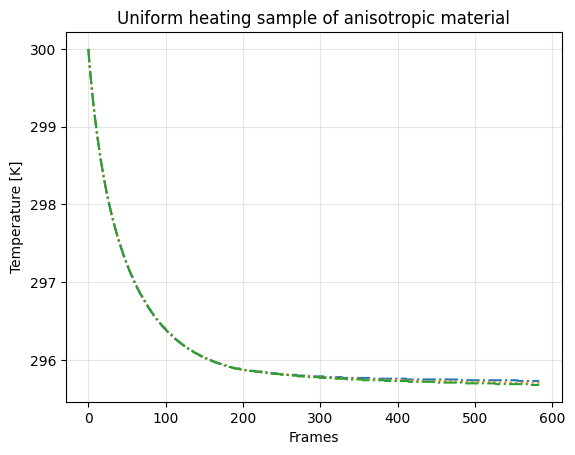

In [7]:
T,Y,X=data.shape
y_center=Y//2
x_center=X//2

plt.plot(data[50:,y_center,x_center]+273.15,linestyle='-.',label='Center point')
plt.plot(data[50:,y_center+100,x_center+100]+273.15,linestyle=':',label='Off-center point 1')
plt.plot(data[50:,y_center-200,x_center-200]+273.15,linestyle='-.',label='Off-center point 2')
plt.xlabel('Frames')
plt.ylabel('Temperature [K]')
plt.title('Uniform heating sample of anisotropic material')
plt.grid(alpha=0.3)


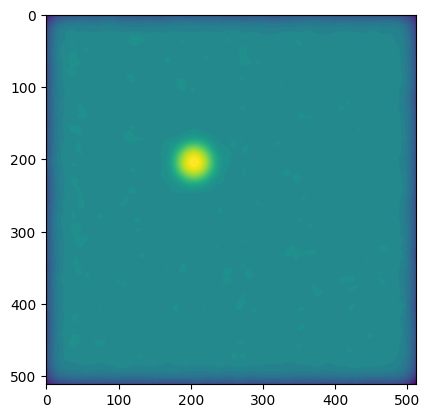

In [8]:
plt.imshow(data[100])

In [9]:
activation_function=nn.Tanh()
x=torch.linspace(-5,5,100,requires_grad=True)
result=activation_function(x)
result.backward(torch.ones_like(x))

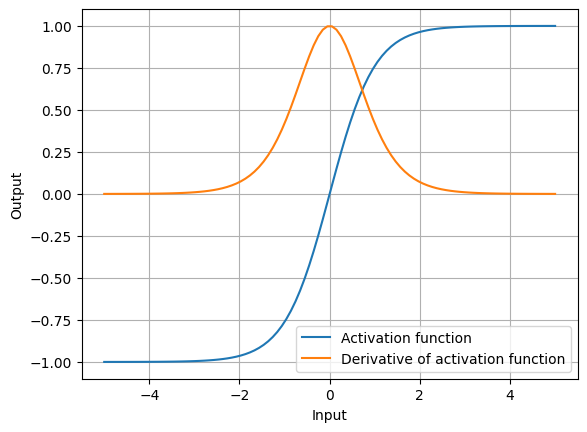

In [10]:
plt.plot(x.detach(),activation_function(x).detach(),label='Activation function')
plt.plot(x.detach(),x.grad.detach(),label='Derivative of activation function')
plt.grid(0.3)
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()


In [11]:
p_data=data+273.15
p_data=p_data[4:,:,:]
p_data.shape

torch.Size([630, 512, 512])

In [12]:
# Shapes
T = p_data          # temperature data, shape (630, 512, 512)
t = torch.linspace(0, 21, 630)
y = torch.linspace(0, 0.1, 512)
x = torch.linspace(0, 0.1, 512)


def NormalizeData(data):
    # Function which normalize data, and outputs its normalized version
    # it also outputs lower and upper bound
    data_max=data.max()
    data_min=data.min()

    normalized_data=2*(data-data_min)/(data_max-data_min)-1
    return normalized_data,data_max,data_min


# Meshgrid
t, y, x = torch.meshgrid(t, y, x, indexing='ij')

# Create mask of valid points (True = valid, False = corrupted)
mask = torch.ones_like(T, dtype=torch.bool)
mask[:, 150:250, 150:250] = False  # exclude this region

# Apply mask to coordinates and data
t_valid = t[mask]
y_valid = y[mask]
x_valid = x[mask]
T_valid = T[mask]

# Concatenate into coordinate tensor
coordis_valid = torch.stack([t_valid, y_valid, x_valid], dim=1)

print(coordis_valid.shape, T_valid.shape)
# e.g. (≈164M - 6.4M, 3), (≈164M - 6.4M,)

torch.Size([158850720, 3]) torch.Size([158850720])


In [13]:
N_samples = 100000
idx = torch.randperm(coordis_valid.shape[0])[:N_samples]

coordis_sampled = coordis_valid[idx]
T_sampled = T_valid[idx]

In [14]:
p_data.shape

torch.Size([630, 512, 512])

In [15]:
N = 10000  # number of collocation points
T_max = 21.0
H = 0.1
W = 0.1

t_rand = T_max * torch.rand(N, 1)
x_rand = W * torch.rand(N, 1)
y_rand = H * torch.rand(N, 1)

# Combine into single tensor
coords_random = torch.cat([t_rand, x_rand, y_rand], dim=1)

In [16]:
coords_random.size()

torch.Size([10000, 3])

In [ ]:
from pyDOE2 import lhs

lhs_samples = lhs(3, samples=100000)
# Normalizing the sampling to -1 and 1 range
lhs_samples = 2 * lhs_samples - 1

# Combining into pytorch tensor
coords_lhs = torch.tensor(lhs_samples, dtype=torch.float32)

In [ ]:
coords_lhs.size()

torch.Size([100000, 3])

In [ ]:
n_dim = 3
n_samples = 10_000

sobol_engine = torch.quasirandom.SobolEngine(dimension=n_dim)
sobol_samples = sobol_engine.draw(n_samples)

# Sobol samples are in [0,1], map to [-1,1]
sobol_samples = 2 * sobol_samples - 1

In [ ]:
sobol_samples.size()

torch.Size([10000, 3])

In [ ]:
data = np.load(r'F:\Synthetic_data_pulse\param_fbh_size10mm_depth30pct_thickness6mm.npz', allow_pickle=True)
data = np.array(data['data'], dtype=np.float32)
data=torch.from_numpy(data)

p_data=data+273.15 # conversion to Kelvin temperature
p_data=p_data[4:,:,:] # Trimming sequence to 21 [s] of recording

T = p_data          # temperature data, shape (630, 512, 512)
time,vertical,horizontal=T.shape

t = torch.linspace(0, 630/30, time) # [0,T_max]
y = torch.linspace(0, 0.1, vertical) # [0, H]
x = torch.linspace(0, 0.1, horizontal) # [0, W]

# Normalizing the data into region of -1 and 1
t_norm,ub_t,lb_t=NormalizeData(t)
y_norm,ub_y,lb_y=NormalizeData(y)
x_norm,ub_x,lb_x=NormalizeData(x)
T_norm,ub_T,lb_T=NormalizeData(T)

# Maintaining limits for reconstruction of them in PDE loss
# Temperature scaling
T_scale = (ub_T - lb_T) / 2.0
scale_t = (ub_t - lb_t) / 2.0
scale_x = (ub_x - lb_x) / 2.0
scale_y = (ub_y - lb_y) / 2.0
scale_z = (0.006) / 2.0 

scales = (T_scale, scale_y, scale_x, scale_t, scale_z)

# Meshgrid
t_grid, y_grid, x_grid = torch.meshgrid(t_norm, y_norm, x_norm, indexing='ij')

# Create mask of valid points (True = valid, False = corrupted)
mask = torch.ones_like(T, dtype=torch.bool)
mask[:, 150:250, 150:250] = False  # exclude this region

# Apply mask to coordinates and data
t_valid = t_grid[mask]
y_valid = y_grid[mask]
x_valid = x_grid[mask]
T_valid = T_norm[mask]